In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor

from micropyome.utils import log
from micropyome.taxa import regression
from micropyome.datasets import normalize

log.silence()

In [2]:
DATASET_PATH = "data/averill_processed/fungi/"
X = {}
Y = {}

for level in regression.TAXONOMIC_LEVELS:
    x = pd.read_csv(f"{DATASET_PATH}{level}/13_variables.csv", float_precision='high')
    y = pd.read_csv(f"{DATASET_PATH}{level}/observed.csv", float_precision='high')

    x = x.drop(x.columns[0], axis=1)
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x)
    y = y.drop(y.columns[0], axis=1)
    if level == "phylum":
        y = y.drop(columns=["other"])

    X[level] = x
    Y[level] = y


Y2 = {}  # Averill et al. results.
for level in regression.TAXONOMIC_LEVELS:
    y2 = pd.read_csv(f"{DATASET_PATH}{level}/predicted.csv")
    y2 = y2.drop(y2.columns[0], axis=1)
    if level == "phylum":
        y2 = y2.drop(columns=["other"])
    Y2[level] = y2


raw_published_results = []
for level in regression.TAXONOMIC_LEVELS:
    r = regression.r2_score_by_column(Y[level], Y2[level])
    raw_published_results.append(np.mean(r))

published_results = []
for level in regression.TAXONOMIC_LEVELS:
    y, y2 = Y[level], Y2[level]
    threshold = 0.01
    for column in y.columns:
        if y[column].mean() < 0.01:
            y = y.drop(columns=[column])
            y2 = y2.drop(columns=[column])
    r = regression.r2_score_by_column(y, y2)
    published_results.append(np.mean(r))

print("Raw published results: ", raw_published_results)
print("Published results: ", published_results)


def graph_results(models: dict, results: dict):
    x = list(range(len(regression.TAXONOMIC_LEVELS)))

    for model in models:
        y = [results[level][model] for level in regression.TAXONOMIC_LEVELS]
        print(f"{model}: {y}")
        plt.plot(x, y, "-o", label=model)

    plt.plot(x, published_results, "-o", label="Averill, filtered")
    plt.plot(x, raw_published_results, "-o", label="Averill, raw")

    plt.xticks(x, regression.TAXONOMIC_LEVELS)
    plt.legend()
    plt.show()

Raw published results:  [-0.2303816133853325, 0.24530457631639052, 0.2190841868852042, 0.09391499642788685, -0.028789786408340443, -0.04117886151694951]
Published results:  [0.20570718904708732, 0.24530457631639052, 0.2190841868852042, 0.13074697958969372, 0.08662931701536375, 0.026894489995128033]


In [9]:
from micropyome.datasets import normalize, normalize_categories

TRANSFER_DATASET_PATH = "data/averill_tranfer"
SAMPLING_LEVELS = ["core", "plot", "site"]

XT = {}
YT = {}
YT2 = {}

for level in regression.TAXONOMIC_LEVELS:
    XT[level] = {}
    YT[level] = {}
    YT2[level] = {}
    x = pd.read_csv(f"{TRANSFER_DATASET_PATH}/Variables/{level}_core_13Var.csv", delimiter=";")
    x = x.drop(x.columns[0], axis=1)
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x)
    y = pd.read_csv(f"{TRANSFER_DATASET_PATH}/Observed/{level}_core_observed.csv")
    y = y.drop(y.columns[0], axis=1)
    if level == "phylum":
        y = y.drop(columns=["other"])
    y = normalize_categories(y)
    z = pd.read_csv(f"{TRANSFER_DATASET_PATH}/Predicted/{level}_core_predicted.csv")
    if level == "phylum":
        z = z.drop(columns=["mean.other"])
    z = z.drop(z.columns[0], axis=1)
    z = normalize_categories(z)
    XT[level] = x
    YT[level] = y
    YT2[level] = z

raw_published_results_T = []
for level in regression.TAXONOMIC_LEVELS:
    r = regression.r2_score_by_column(YT[level], YT2[level])
    raw_published_results_T.append(np.mean(r))

published_results_T = []
for level in regression.TAXONOMIC_LEVELS:
    y, y2 = YT[level], YT2[level]
    threshold = 0.01
    for column in y.columns:
        if y[column].mean() < 0.01:
            y = y.drop(columns=[column])
            y2 = y2.drop(columns=["mean." + column])
    r = regression.r2_score_by_column(y, y2)
    published_results_T.append(np.mean(r))

print("Raw published results: ", raw_published_results_T)
print("Published results: ", published_results_T)


def graph_results_T(models: dict, results: dict):
    x = list(range(len(regression.TAXONOMIC_LEVELS)))

    for model in models:
        y = results[model]
        print(f"{model}: {y}")
        plt.plot(x, y, "-o", label=model)

    plt.plot(x, published_results_T, "-o", label="Averill, filtered")

    plt.xticks(x, regression.TAXONOMIC_LEVELS)
    plt.legend()
    plt.show()

Raw published results:  [-1.6267933925463198, -0.6785502923288386, -1.8851452380286347, -6.0319270033666985, -1.3027986215287682e+32, -2.305791205607328e+32]
Published results:  [-0.1185652895373612, -0.6785502923288386, -1.1300106505128609, -0.189889386877197, -0.31207666553627655, -0.46704081417190374]


In [7]:
def test_model(model):
    results = {}
    for level in regression.TAXONOMIC_LEVELS:
        model.fit(X[level], Y[level])
        r = regression.evaluate(model, XT[level], YT[level], threshold=0.01)
        results[level] = np.mean(r)
    return results

## Logit

Logit: dict_values([-0.2864462413352623, -0.37398264972707274, -0.7315586883730212, -0.4705905398504253, -0.5981716929680735, -0.5821937482566063])
Linear: dict_values([-0.2868153272117551, -0.6033595581890289, -1.253695277846255, -0.46456087220516634, -0.8156604187028081, -1.1592314646641229])


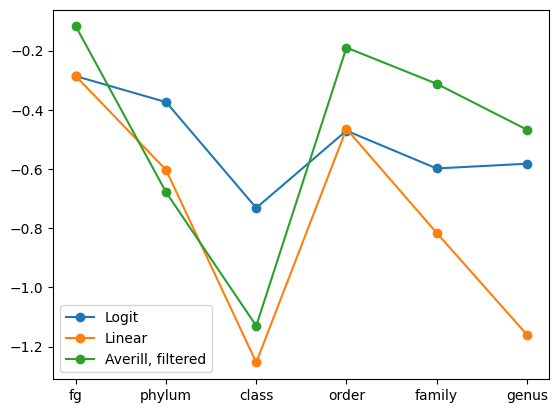

In [13]:
class LogitRegression(LinearRegression):

    def fit(self, x, p):
        p = np.asarray(p)
        y = np.log(p / (1 - p))
        y = np.nan_to_num(y, nan=0)
        return super().fit(x, y)

    def predict(self, x):
        y = super().predict(x)
        return 1 / (np.exp(-y) + 1)


models = {
    "Logit": LogitRegression(),
    "Linear": LinearRegression()
}
r1 = test_model(LogitRegression())
r2 = test_model(LinearRegression())

graph_results_T(models, {"Logit": r1.values(), "Linear": r2.values()})

## K-NN

k-NN: dict_values([-0.39316198422287235, -0.5789210838399629, -0.966374185987006, -0.5179432707300073, -0.9470712813624879, -1.4061833761743676])


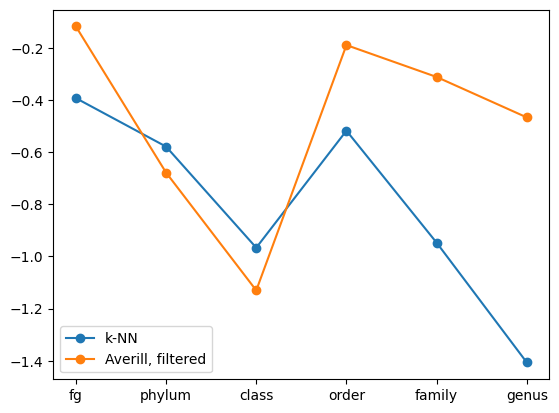

In [14]:
models = {
    "k-NN": KNeighborsRegressor(10)
}
r1 = test_model(KNeighborsRegressor(10))

graph_results_T(models, {"k-NN": r1.values()})

## DT

DT: dict_values([-0.7046958045855132, -2.1439392596660873, -2.5472959361318313, -0.9306777871645802, -2.519137050880932, -2.4334623455623663])


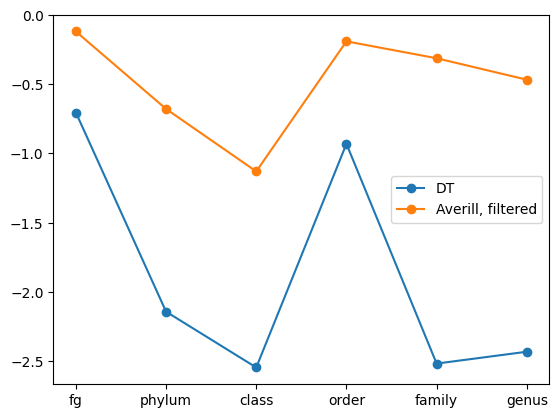

In [15]:
models = {
    "DT": DecisionTreeRegressor()
}
r1 = test_model(DecisionTreeRegressor())

graph_results_T(models, {"DT": r1.values()})

## RF

RF: dict_values([-0.12251030403589742, -0.36024061196315843, -1.0349632520044336, -0.44276941415308707, -0.8383503829563543, -1.0259064200017167])


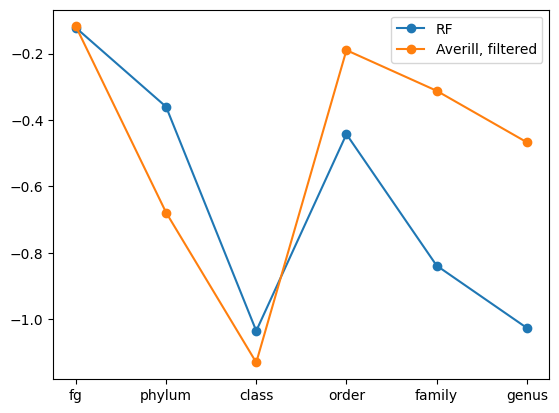

In [16]:
models = {
    "RF": RandomForestRegressor()
}
r1 = test_model(RandomForestRegressor())

graph_results_T(models, {"RF": r1.values()})